In [72]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout,MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from functions import plot_images, emotion_detection

In [73]:
print(tf.__version__)

2.5.0


In [74]:
gpus = len(tf.config.list_physical_devices('GPU'))

In [75]:
print("Num GPUs Available: ", gpus)

Num GPUs Available:  1


In [76]:
#unzip data 
path_to_zip_file = 'fer2013.zip'
directory_to_extract_to = 'fer2013'
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

FileNotFoundError: [Errno 2] No such file or directory: 'fer2013.zip'

In [78]:
DIR_TRAIN = './fer2013/train'
DIR_TEST = './fer2013/test'
BATCH_SIZE=64
IMG_SIZE=(48, 48)
IMG_SHAPE=IMG_SIZE + (3,)
FRACTION=0.3

In [79]:
train_data = image_dataset_from_directory(
    DIR_TRAIN,
    labels="inferred",
    label_mode="categorical",
    # color_mode='grayscale',
     subset='training',
    validation_split=FRACTION,
    shuffle=True,
    seed=42,
    image_size=IMG_SIZE
)

Found 28709 files belonging to 7 classes.
Using 20097 files for training.


In [80]:
val_data = image_dataset_from_directory(
    DIR_TRAIN,
    labels="inferred",
    label_mode="categorical",
    # color_mode='grayscale',
     subset='validation',
    validation_split=FRACTION,
    shuffle=True,
    seed=42,
    image_size=IMG_SIZE
)

Found 28709 files belonging to 7 classes.
Using 8612 files for validation.


In [81]:
test_data = image_dataset_from_directory(
    DIR_TEST,
    labels="inferred",
    label_mode="categorical",
    # color_mode='grayscale',
    seed=42,
    image_size=IMG_SIZE
)

Found 7178 files belonging to 7 classes.


In [82]:
train_data

<BatchDataset shapes: ((None, 48, 48, 3), (None, 7)), types: (tf.float32, tf.float32)>

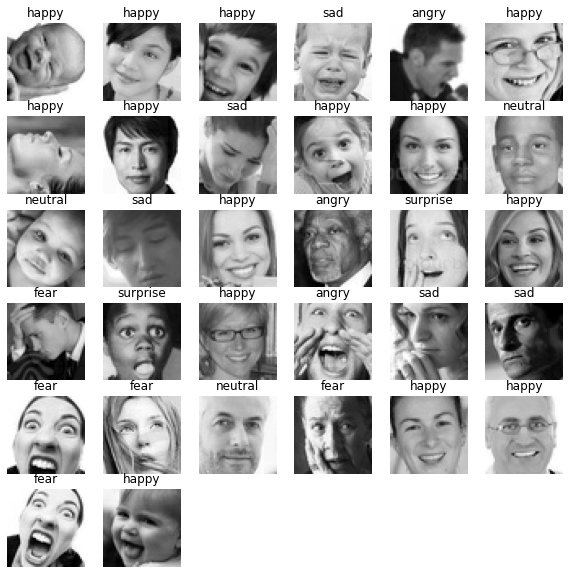

In [83]:
plot_images(train_data)

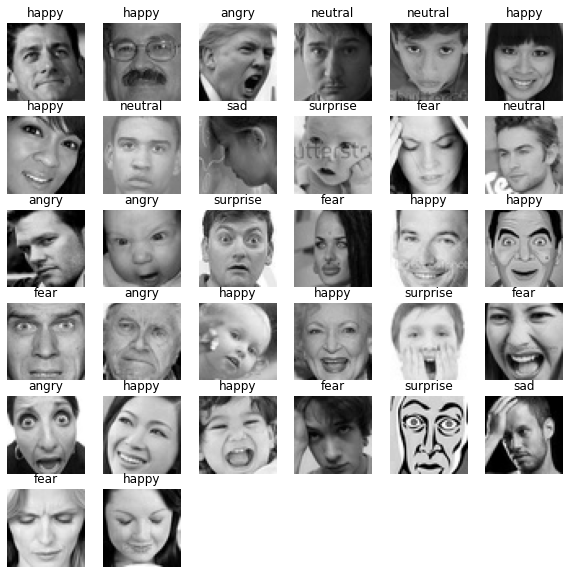

In [84]:
plot_images(test_data)

In [85]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [86]:
train_data = train_data.map(process)
val_data = val_data.map(process)
test_data = test_data.map(process)

In [89]:
EPOCHS = 50

In [90]:
#define callbacks
def get_checkpoint(name):
    checkpoint_filepath = f'./{name}/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='accuracy',
        mode='max',
        save_best_only=True)
    return [model_checkpoint_callback]

In [91]:
def train_model(model, data, num_epoch, callbacks):
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001, decay=1e-6),
                  metrics=['accuracy'])
    gpus = len(tf.config.list_physical_devices('GPU'))
    if (gpus != 0):
        device = '/GPU:0'
    else:
        device = '/CPU:0'
    with tf.device(device):
        model_info = model.fit(
                train_data,
                steps_per_epoch=len(data[0]),
                epochs=num_epoch,
                validation_data=data[1],
                validation_steps=len(data[1]),
                callbacks=callbacks)
    return model_info

In [92]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.optimizers import Adam

In [93]:
def get_model(model_arch):
    pretrained_model = model_arch(include_top=False,
                         pooling='none',
                         input_shape=(48, 48, 3),
                         weights='imagenet')
    pretrained_model.trainable = False
    x = GlobalMaxPooling2D()(pretrained_model.output)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    output = Dense(7, activation='softmax')(x)
    return Model(pretrained_model.input, output)  

In [94]:
custom_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu',
           input_shape=IMG_SHAPE),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')])
custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 46, 46, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 256)        

In [95]:
from tensorflow.keras.applications import VGG16
vgg16_model = get_model(VGG16)
vgg16_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [96]:
from tensorflow.keras.applications import EfficientNetB0
efficientNetB0_model = get_model(EfficientNetB0)
efficientNetB0_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 48, 48, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 48, 48, 3)    7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 49, 49, 3)    0           normalization_2[0][0]            
____________________________________________________________________________________________

In [97]:
from tensorflow.keras import backend as K
    
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [98]:
def plot_trainig_history(history):
    # Plot learning curve
    plt.figure(figsize=(15,15))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['loss','val_loss'], loc='upper right',prop={'size': 15});
    plt.title('Learning curve for the training of Dense Layers', fontsize=15)
    plt.show()
    print('Best test F1 score: ' + str(max(history.history['val_f1'])))

In [99]:
history_custom_model = train_model(model=custom_model, data=(train_data, val_data),
                                   num_epoch=EPOCHS,
                                   callbacks=get_checkpoint('custom'))

Epoch 1/50
629/629 [==============================] - 31s 48ms/step - loss: 1.7934 - accuracy: 0.2664 - val_loss: 1.6706 - val_accuracy: 0.3604
Epoch 2/50
629/629 [==============================] - 29s 46ms/step - loss: 1.5964 - accuracy: 0.3811 - val_loss: 1.5044 - val_accuracy: 0.4223
Epoch 3/50
629/629 [==============================] - 28s 44ms/step - loss: 1.4804 - accuracy: 0.4327 - val_loss: 1.4304 - val_accuracy: 0.4626
Epoch 4/50
629/629 [==============================] - 28s 44ms/step - loss: 1.3991 - accuracy: 0.4677 - val_loss: 1.3510 - val_accuracy: 0.4880
Epoch 5/50
629/629 [==============================] - 28s 44ms/step - loss: 1.3315 - accuracy: 0.4943 - val_loss: 1.3015 - val_accuracy: 0.5091
Epoch 6/50
629/629 [==============================] - 28s 44ms/step - loss: 1.2710 - accuracy: 0.5187 - val_loss: 1.2685 - val_accuracy: 0.5239
Epoch 7/50
629/629 [==============================] - 28s 44ms/step - loss: 1.2071 - accuracy: 0.5464 - val_loss: 1.2473 - val_accuracy:

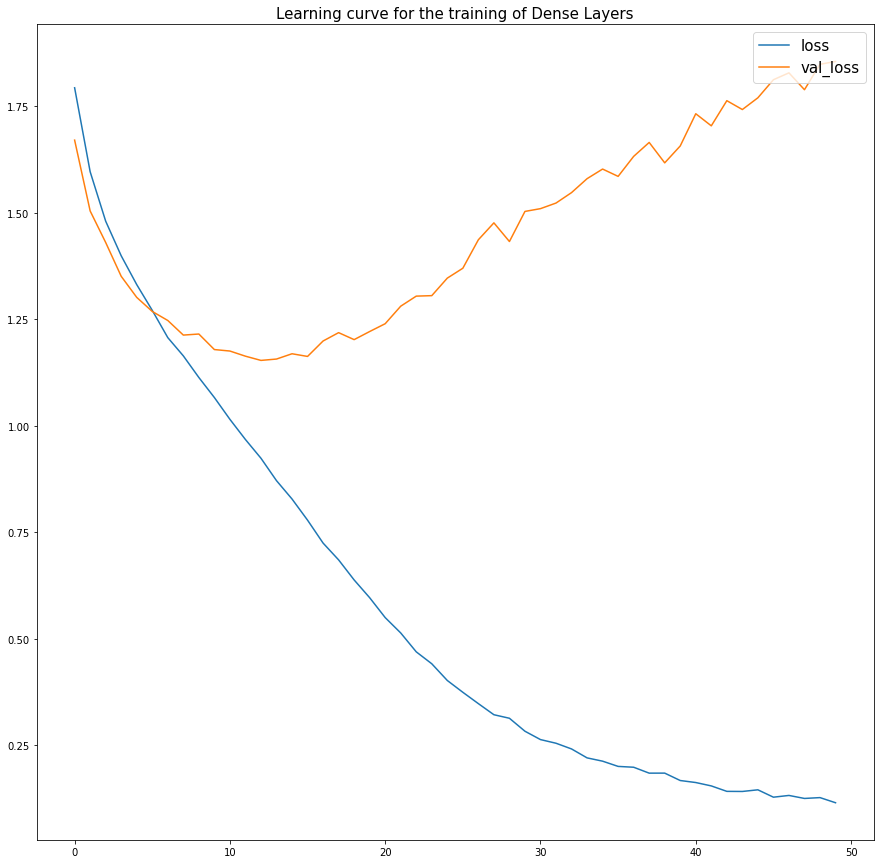

KeyError: 'val_f1'

In [100]:
plot_trainig_history(history_custom_model)

In [247]:
history_vgg16 = train_model(model=vgg16_model, data=(train_data, val_data),
                                   num_epoch=EPOCHS,
                                   callbacks=get_checkpoint('vgg16'))

Epoch 1/10
315/315 [==============================] - 72s 224ms/step - loss: 2.7660 - accuracy: 0.3135 - f1: 0.2904 - val_loss: 2.3380 - val_accuracy: 0.3315 - val_f1: 0.2963
Epoch 2/10
315/315 [==============================] - 66s 209ms/step - loss: 1.6261 - accuracy: 0.4502 - f1: 0.4132 - val_loss: 2.2973 - val_accuracy: 0.3213 - val_f1: 0.2959
Epoch 3/10
315/315 [==============================] - 64s 203ms/step - loss: 1.2980 - accuracy: 0.5456 - f1: 0.5175 - val_loss: 1.9244 - val_accuracy: 0.3926 - val_f1: 0.3556
Epoch 4/10
315/315 [==============================] - 65s 207ms/step - loss: 1.0307 - accuracy: 0.6351 - f1: 0.6099 - val_loss: 2.1926 - val_accuracy: 0.3670 - val_f1: 0.3489
Epoch 5/10
315/315 [==============================] - 66s 210ms/step - loss: 0.9072 - accuracy: 0.6867 - f1: 0.6712 - val_loss: 2.1479 - val_accuracy: 0.3922 - val_f1: 0.3720
Epoch 6/10
315/315 [==============================] - 66s 210ms/step - loss: 0.7619 - accuracy: 0.7381 - f1: 0.7252 - val_los

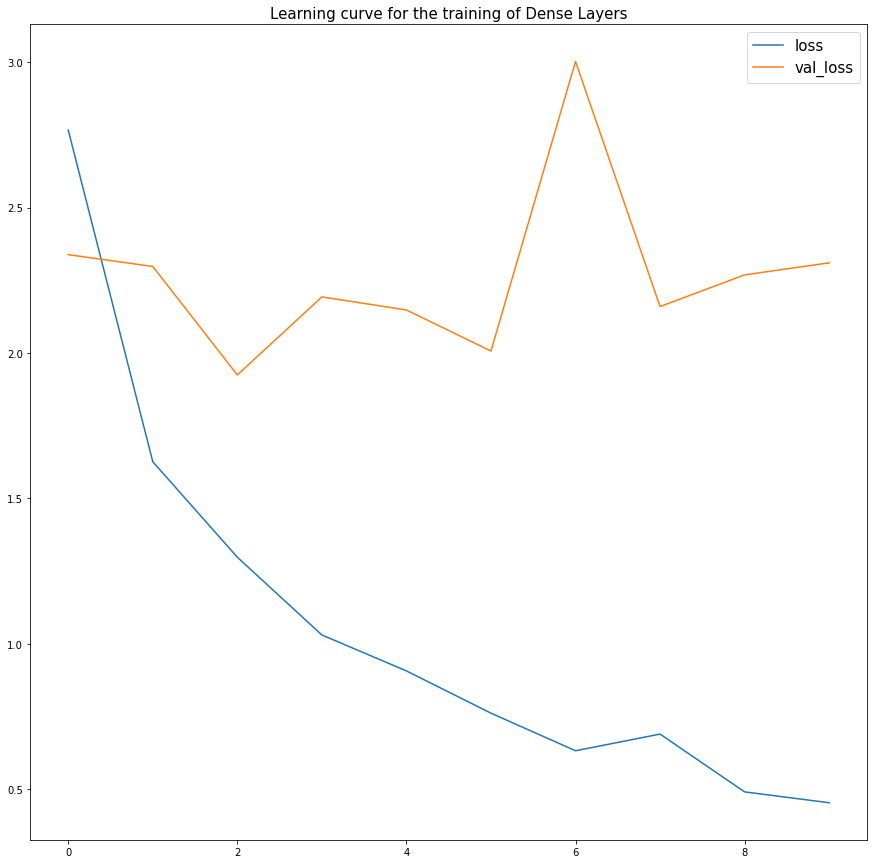

Best test F1 score: 0.3967440724372864


In [250]:
plot_trainig_history(history_vgg16)

In [61]:
history_efficientNetB0 = train_model(model=efficientNetB0_model, data=(train_data, val_data),
                                   num_epoch=EPOCHS,
                                   callbacks=get_checkpoint('efficientNetB0'))

Epoch 1/50
629/629 [==============================] - 64s 78ms/step - loss: 1.8222 - accuracy: 0.2484 - f1: 0.0000e+00 - val_loss: 1.8147 - val_accuracy: 0.2447 - val_f1: 0.0000e+00
Epoch 2/50
629/629 [==============================] - 43s 68ms/step - loss: 1.8154 - accuracy: 0.2541 - f1: 0.0000e+00 - val_loss: 1.8129 - val_accuracy: 0.2447 - val_f1: 0.0000e+00
Epoch 3/50
629/629 [==============================] - 42s 67ms/step - loss: 1.8129 - accuracy: 0.2542 - f1: 0.0000e+00 - val_loss: 1.8129 - val_accuracy: 0.2447 - val_f1: 0.0000e+00
Epoch 4/50
629/629 [==============================] - 45s 71ms/step - loss: 1.8122 - accuracy: 0.2542 - f1: 0.0000e+00 - val_loss: 1.8161 - val_accuracy: 0.2447 - val_f1: 0.0000e+00
Epoch 5/50
629/629 [==============================] - 44s 71ms/step - loss: 1.8116 - accuracy: 0.2542 - f1: 0.0000e+00 - val_loss: 1.8164 - val_accuracy: 0.2447 - val_f1: 0.0000e+00
Epoch 6/50
629/629 [==============================] - 42s 67ms/step - loss: 1.8111 - accur

KeyboardInterrupt: 

In [ ]:
plot_trainig_history(history_efficientNetB0)

In [46]:
from functions import emotion_detection
#pass model for
emotion_detection(vgg16_model)

In [101]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

TypeError: 'float' object is not iterable

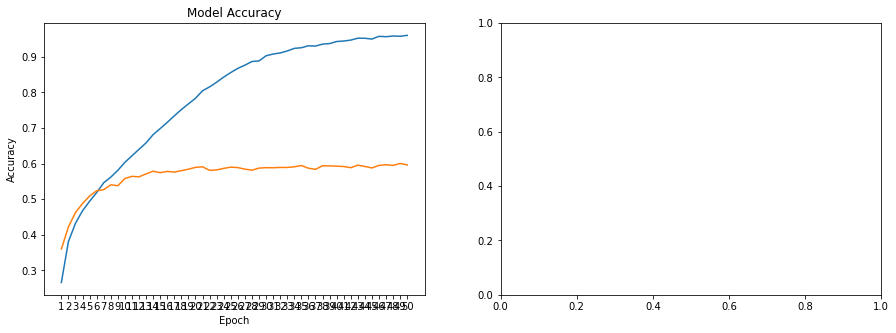

In [102]:
plot_model_history(history_custom_model)